## 멀티 에이전트 슈퍼바이저(Multi-agent supervisor)

[슈퍼바이저(supervisor)](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor)는 중앙 슈퍼바이저 에이전트가 전문 에이전트들을 조정하는 다중 에이전트 아키텍처입니다. 
슈퍼바이저 에이전트는 모든 통신 흐름과 작업 위임을 제어하며, 현재 상황과 작업 요구사항에 따라 호출할 에이전트를 결정합니다.

이 튜토리얼에서는 연구 전문가와 수학 전문가라는 두 에이전트로 구성된 슈퍼바이저 시스템을 구축합니다. 
튜토리얼을 마치면 다음을 수행할 수 있습니다:

*   전문 연구 및 수학 에이전트 구축
*   사전 구축된 langgraph-supervisor를 사용하여 이를 조정하는 슈퍼바이저 구축
*   슈퍼바이저를 처음부터 구축
*   고급 작업 위임 구현

![](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/assets/diagram.png)

**참고**

- 관련 논문: https://arxiv.org/abs/2405.16510
- 슈퍼바이저 에이전트 개념: https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor
- 랭그래프 공식 튜토리얼: https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/

## 환경 설정

먼저 필요한 패키지를 설치하고 API 키를 설정해 보겠습니다.

In [55]:
%%capture --no-stderr
%pip install -Uq langgraph langgraph-supervisor langchain-tavily "langchain[openai]"

In [1]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## 1. 작업 에이전트 생성

먼저, 연구 에이전트와 수학 에이전트라는 특수 작업 에이전트를 생성해 보겠습니다:

연구 에이전트는 [Tavily API](https://tavily.com/)를 사용하는 웹 검색 도구에 접근할 수 있습니다.
수학 에이전트는 간단한 수학 도구(덧셈, 곱셈, 나눗셈)에 접근할 수 있습니다.

### 연구 에이전트
웹 검색을 위해 `langchain-tavily`의 [`TavilySearch`](https://python.langchain.com/api_reference/tavily/tavily_search/langchain_tavily.tavily_search.TavilySearch.html) 도구를 사용할 것입니다:

In [2]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("서울시의 시장은 누구입니까?")

print(web_search_results["results"][0]["content"])

| ▲ 오세훈 서울시장이 2025년 2월26일 서울 중구 서울시청에서 열린 제4회 서울시 안보포럼 ‘트럼프 2기, 한반도 안보의 길을 묻다’에서 환영사를 하고 있다. △서울시 공식 슬로건 ‘Seoul, my soul(서울, 마이 소울)’ 내걸어 오세훈은 2023년 8월16일 박원순 전 서울시장 때 선정된 서울시 공식 슬로건 ‘I·SEOUL·U(아이서울유)’를 ‘Seoul, my soul(서울, 마이 소울)’로 바꿨다. △4‧7재보선에서 서울시장 당선 오세훈은 2021년 4월7일 박원순 전 시장의 유고로 치러진 서울시장 보궐선거에서 국민의힘 후보로 출마한 뒤 당선돼 10년 만에 서울시장에 복귀했다. 오세훈은 2021년 4월 서울시장 보궐선거를 앞두고 명태균씨 측에서 실시한 여론조사 비용을 사업가 김한정씨에게 대납하게 한 의혹을 받고 있다. 오세훈은 2021년 4월 서울시장 보궐선거를 앞두고 명태균 측에서 실시한 여론조사 비용을 사업가 김한정에게 대납하게 한 의혹을 받고 있다. | ▲ 오세훈 서울시장이 2025년 2월12일 서울 국회 도서관에서 열린 ‘87체제 극복을 위한 지방분권 개헌 토론회’에 입장하고 있다.


개별 작업자 에이전트를 생성하기 위해 LangGraph의 사전 구축된 [에이전트](https://langchain-ai.github.io/langgraph/agents/agents/)를 사용할 것입니다.

In [3]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[web_search],
    prompt=(
        "당신은 연구 에이전트입니다.\n\n"
        "INSTRUCTIONS:\n"
        "- 연구 관련 작업에만 협조하십시오. 수학 문제는 절대 수행하지 마십시오.\n"
        "- 작업 완료 후에는 감독관에게 직접 응답하십시오.\n"
        "- 작업 결과만 응답하십시오. 다른 텍스트는 절대 포함하지 마십시오."
    ),
    name="research_agent",
)

[에이전트를 실행](https://langchain-ai.github.io/langgraph/agents/run_agents/)하여 예상대로 동작하는지 확인해 봅시다.

In [4]:
# 스트리밍 에이전트 출력을 깔끔하게 렌더링하기 위해
# pretty_print_messages 헬퍼를 사용할 것입니다
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [5]:
for chunk in research_agent.stream(
    {"messages": [("user", "서울시의 시장은 누구입니까?")]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_kRJTJe0C3jko8yCcf3g6ir86)
 Call ID: call_kRJTJe0C3jko8yCcf3g6ir86
  Args:
    query: 서울시 시장
    include_domains: ['seoul.go.kr']
    search_depth: basic


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "서울시 시장", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.seoul.go.kr/seoul/mayor.do", "title": "역대서울시장 | 서울특별시", "content": "+ 비정규직의 정규직화, 골목상권보호 등 상생협력 문화 정착을 통한 경제민주화도시 서울 추진 + 도시기반시설 노후화 대비, 지하철 안전강화 등 안전도시 서울 추진 + 창의시정(120다산콜센터, 천만상상오아시스 등) 추진 + WDC 2010 유치, 동대문디자인파크플라자 건설 등 디자인서울 정책 추진 + 청계천 생태하천 복원, 서울숲 조성 등 친환경시정 추진 서울의제 21 등 환경정책 적극 추진 + 제2기 지하철 건설 추진 및 내부순환 및 북부간선도로 등 도시고속도로 착공 + 빗물펌프장 확충 및 정비, 제방축조 등 항구적인 수방대책 수립 추진 + 상수도 공급, 청소, 주택공급, 복지시설 확충 등 서민생활보호대책 추진 + 청소행정의 혁신, 도시가스시설 확충 및 의료보험

## 수학 에이전트
수학 에이전트 도구에는 [기본 파이썬 함수](https://langchain-ai.github.io/langgraph/how-tos/tool-calling/#define-a-tool)를 사용할 것입니다:

In [6]:
def add(a: float, b: float):
    """두 수를 더합니다."""
    return a + b


def multiply(a: float, b: float):
    """두 수를 곱합니다."""
    return a * b


def divide(a: float, b: float):
    """두 수를 나눕니다."""
    return a / b


math_agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[add, multiply, divide],
    prompt=(
        "당신은 수학 에이전트입니다.\n\n"
        "INSTRUCTIONS:\n"
        "- 오직 수학 관련 작업만 지원하십시오\n"
        "- 작업 완료 후에는 감독관에게 직접 응답하십시오\n"
        "- 오직 작업 결과만 응답하고, 그 외 어떤 텍스트도 포함하지 마십시오."
    ),
    name="math_agent",
)

수학 에이전트를 실행해 보자:

In [7]:
for chunk in math_agent.stream({"messages": [("user", "(3 + 5) × 7은 얼마인가요?")]}):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_kEXvrpjaHAa3OCVczrwZYpVl)
 Call ID: call_kEXvrpjaHAa3OCVczrwZYpVl
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (call_yRKBT5vpobtbPLXEtteMRKB5)
 Call ID: call_yRKBT5vpobtbPLXEtteMRKB5
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

(3 + 5) × 7은 56입니다.




## 2. `langgraph-supervisor`로 슈퍼바이저 생성하기
다중 에이전트 시스템을 구현하기 위해 사전 구축된 `langgraph-supervisor` 라이브러리의 [`create_supervisor`](https://langchain-ai.github.io/langgraph/reference/supervisor/#langgraph_supervisor.supervisor.create_supervisor)를 사용할 것입니다:

In [8]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4.1-mini"),
    agents=[research_agent, math_agent],
    prompt=(
        "당신은 두 명의 에이전트를 관리하는 감독관입니다:\n"
        "- research 에이전트: 연구 관련 작업을 이 에이전트에게 할당하십시오\n"
        "- math 에이전트: 수학 관련 작업을 이 에이전트에게 할당하십시오\n"
        "한 번에 한 명의 에이전트에게만 작업을 할당하고, 에이전트를 동시에 호출하지 마십시오.\n"
        "직접 어떤 작업도 수행하지 마십시오."
    ),
    add_handoff_back_messages=True,  # handoff 메시지 추가
    output_mode="full_history",
).compile()

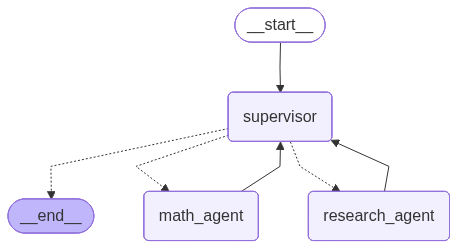

In [9]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

**참고**: 이 코드를 실행하면 슈퍼바이저 에이전트와 작업자 에이전트 간의 흐름을 보여주는 슈퍼바이저 그래프의 시각적 표현이 생성되어 표시됩니다.

이제 두 에이전트 모두를 필요로 하는 쿼리로 실행해 보겠습니다:

- 연구 에이전트는 필요한 GDP 정보를 조회합니다
- 수학 에이전트는 요청된 대로 뉴욕 주 GDP의 비율을 구하기 위해 나눗셈을 수행합니다

In [10]:
query = "2024년 미국 및 뉴욕 주의 국내총생산(GDP)을 찾아보십시오. 뉴욕 주의 GDP가 미국 GDP에서 차지하는 비율은 얼마입니까?"

for chunk in supervisor.stream(
    {"messages": [("user", query)]},
):
    pretty_print_messages(chunk, last_message=True)

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

2024년 미국 GDP 성장률은 약 2.3~2.7% 사이로 전망되며, 뉴욕 주의 경제 성장률은 약 2.4%로 미국 전체와 비슷하거나 다소 높게 예상됩니다. 뉴욕 주가 미국 GDP에서 차지하는 비율은 구체 수치는 없으나, 대략 8~10% 수준으로 추정됩니다. 추가로 구체적인 공식 수치를 원하시면 알려주세요.




In [11]:
final_message_history = chunk["supervisor"]["messages"]
print(final_message_history)

[HumanMessage(content='2024년 미국 및 뉴욕 주의 국내총생산(GDP)을 찾아보십시오. 뉴욕 주의 GDP가 미국 GDP에서 차지하는 비율은 얼마입니까?', additional_kwargs={}, response_metadata={}, id='859cd2ba-0eac-4686-9779-344ff053be46'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KjHciNugUHinmpIcVRO7I29H', 'function': {'arguments': '{}', 'name': 'transfer_to_research_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 198, 'total_tokens': 211, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_c064fdde7c', 'id': 'chatcmpl-CPfNyN5nS30paNITF5aGGfCnbktEm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--d5922805-62c1-4e66-a975-1f71fe31596b-0', tool_calls=[{'name': 'tr

## 3. 슈퍼바이저 에이전트부터 새로 만들기
이제 동일한 다중 에이전트 시스템을 처음부터 구현해 보겠습니다. 다음을 수행해야 합니다:

1. [감독 에이전트가 개별 에이전트와 통신하는 방식 설정](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/#set-up-agent-communication)
2. [감독 에이전트 생성](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/#create-supervisor-agent)
3. 감독 에이전트와 작업자 에이전트를 [단일 다중 에이전트 그래프](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/#create-multi-agent-graph)로 결합.

### 에이전트 통신 설정

슈퍼바이저 에이전트가 워커 에이전트들과 통신할 수 있는 방식을 정의해야 합니다. 다중 에이전트 아키텍처에서 이를 구현하는 일반적인 방법은 한 에이전트가 다른 에이전트에게 제어권을 넘기는 핸드오프를 사용하는 것입니다. 핸드오프를 통해 다음을 지정할 수 있습니다:

- **destination**: 제어권을 넘길 대상 에이전트
- **payload**: 해당 에이전트에 전달할 정보

우리는 핸드오프 도구를 통해 핸드오프를 구현하고 이 도구들을 관리자 에이전트에 제공할 것입니다: 관리자가 이 도구들을 호출하면, 전체 메시지 기록을 해당 에이전트에 전달하며 제어권을 작업자 에이전트에게 넘깁니다.

In [ ]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command
from langchain_core.messages import ToolMessage


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    tool_name = f"transfer_to_{agent_name}"
    description = description or f"{agent_name}에게 도움을 요청하세요."

    @tool(tool_name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = ToolMessage(
            f"{agent_name}에게 성공적으로 이관되었습니다.",
            name=tool_name,
            tool_call_id=tool_call_id,
        )
        return Command(
            goto=agent_name,
            update={**state, "messages": state["messages"] + [tool_message]},
            graph=Command.PARENT,
        )

    return handoff_tool


# Handoffs
assign_to_research_agent = create_handoff_tool(
    agent_name="research_agent",
    description="연구자 에이전트에게 작업을 할당하십시오.",
)

assign_to_math_agent = create_handoff_tool(
    agent_name="math_agent",
    description="수학 에이전트에게 작업을 할당하십시오.",
)

### 슈퍼바이저 에이전트 생성
이제 방금 정의한 핸드오프 도구를 사용하여 슈퍼바이저 에이전트를 생성해 보겠습니다. 

미리 빌드된 [`create_react_agent`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent)를 사용할 것입니다:

In [18]:
supervisor_agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[assign_to_research_agent, assign_to_math_agent],
    prompt=(
        "당신은 두 명의 에이전트를 관리하는 감독관입니다:\n"
        "- research 에이전트: 연구 관련 작업을 이 에이전트에게 할당하십시오\n"
        "- math 에이전트: 수학 관련 작업을 이 에이전트에게 할당하십시오\n"
        "한 번에 한 명의 에이전트에게만 작업을 할당하고, 에이전트를 동시에 호출하지 마십시오.\n"
        "직접 어떤 작업도 수행하지 마십시오."
    ),
    name="supervisor",
)

### 다중 에이전트 그래프 생성

이 모든 것을 종합하여 전체 다중 에이전트 시스템을 위한 그래프를 생성해 보겠습니다. 

슈퍼바이저와 개별 에이전트를 하위 그래프 노드로 추가할 것입니다.

In [19]:
from langgraph.graph import END

# 다중 에이전트 슈퍼바이저 그래프 정의
supervisor = (
    StateGraph(MessagesState)
    # 참고: `destinations`는 시각화 목적으로만 필요하며 런타임 동작에는 영향을 미치지 않습니다.
    .add_node(supervisor_agent, destinations=("research_agent", "math_agent", END))
    .add_node(research_agent)
    .add_node(math_agent)
    # 항상 슈퍼바이저에게 보고하십시오
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .set_entry_point("supervisor")
    .compile()
)

작업 에이전트에서 감독자로 명시적인 에지를 추가했음을 확인하십시오. 이는 에이전트가 반드시 제어권을 감독자에게 반환함을 의미합니다. 에이전트가 사용자에게 직접 응답하도록 하려면(즉, 시스템을 라우터로 전환하려면) 이 에지들을 제거할 수 있습니다.

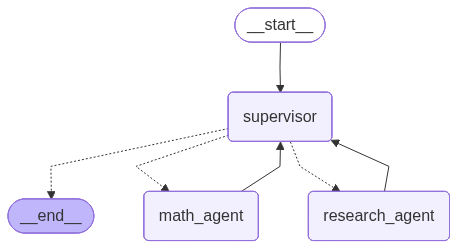

In [15]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

다중 에이전트 그래프가 생성되었으니, 이제 실행해 보겠습니다!

In [20]:
for chunk in supervisor.stream({"messages": [("user", query)]}):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

research_agent에게 성공적으로 이관되었습니다.


Update from node research_agent:


================================== Ai Message ==================================
Name: research_agent

2024년 미국 전체 국내총생산(GDP)은 실질 기준으로 약 2.8% 성장한 것으로 나타났으며, 구체적인 금액은 미국 경제분석국(BEA) 발표를 참고하면 됩니다.

뉴욕 주의 2024년 GDP 수치는 현재 BEA에서 신속한 분기별 자료가 있으나, 전체 연간 수치는 아직 명확히 제시되지 않은 상태입니다. 다만, 뉴욕 주는 미국 내 경제 규모 상위권에 위치하므로 미국 GDP에서 차지하는 비율은 약 8~9% 내외일 것으로 추정됩니다.

정확한 수치가 BEA에서 2024년 전체 연간 GDP 보고서 발표 시 업데이트될 예정입니다.

더 구체적인 값이나 최신 자료 조회가 필요하면 알려주십시오.


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

2024년 미국 전체 GDP는 실질 기준으로 약 2.8% 성장한 것으로 BEA에서 발표했습니다. 뉴욕 주 GDP의 구체적인 2024년 연간 값은 아직 명확하게 나오지 않았으나, 과거 및 분기별 데이터를 참고할 때 뉴욕 주 GDP가 미국 전체 GDP에서 차지하는 비율은 대략 8~9%로 예상됩니다.

더 구체적이고 최신 데이터가 필요하시면, 추가 조사를 요청해 주세요.




## 4. 위임 작업 생성

지금까지 개별 에이전트는 전체 메시지 기록을 해석하여 자신의 작업을 결정해 왔습니다. 대안적인 접근법은 감독자에게 작업을 명시적으로 정의하도록 요청하는 것입니다. `handoff_tool` 함수에 `task_description` 매개변수를 추가함으로써 이를 구현할 수 있습니다.


In [ ]:
from langgraph.types import Send


def create_task_description_handoff_tool(
    *, agent_name: str, description: str | None = None
):
    tool_name = f"transfer_to_{agent_name}"
    description = description or f"{agent_name}에게 도움을 요청하세요."

    @tool(tool_name, description=description)
    def handoff_tool(
        # 이것은 감독자 LLM에 의해 채워집니다
        task_description: Annotated[
            str,
            "다음 에이전트가 수행해야 할 작업에 대한 설명으로, 모든 관련 컨텍스트를 포함합니다.",
        ],
        # 이러한 매개변수들은 LLM에 의해 무시됩니다
        state: Annotated[MessagesState, InjectedState],
    ) -> Command:
        return Command(
            goto=[
                Send(
                    agent_name,
                    {
                        **state,
                        "messages": [("user", task_description)],
                    },
                )
            ],
            graph=Command.PARENT,
        )

    return handoff_tool


assign_to_research_agent_with_description = create_handoff_tool(
    agent_name="research_agent",
    description="연구자 에이전트에게 작업을 할당하십시오.",
)

assign_to_math_agent_with_description = create_handoff_tool(
    agent_name="math_agent",
    description="수학 에이전트에게 작업을 할당하십시오.",
)

supervisor_agent_with_description = create_react_agent(
    model="openai:gpt-4.1",
    tools=[
        assign_to_research_agent_with_description,
        assign_to_math_agent_with_description,
    ],
    prompt=(
        "당신은 두 명의 에이전트를 관리하는 감독관입니다:\n"
        "- research 에이전트: 연구 관련 작업을 이 에이전트에게 할당하십시오\n"
        "- math 에이전트: 수학 관련 작업을 이 에이전트에게 할당하십시오\n"
        "한 번에 한 명의 에이전트에게만 작업을 할당하고, 에이전트를 동시에 호출하지 마십시오.\n"
        "직접 어떤 작업도 수행하지 마십시오."
    ),
    name="supervisor",
)

supervisor_with_description = (
    StateGraph(MessagesState)
    .add_node(
        supervisor_agent_with_description, destinations=("research_agent", "math_agent")
    )
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .set_entry_point("supervisor")
    .compile()
)

**참고**: 여기에서는 `handoff_tool`에서 [`Send()`](https://langchain-ai.github.io/langgraph/reference/types/#langgraph.types.Send) 기본 기능을 사용하고 있습니다. 이는 각 작업 에이전트가 전체 `supervisor` 그래프 상태를 입력으로 받는 대신 Send 페이로드의 내용만 볼 수 있음을 의미합니다. 이 예시에서는 작업 설명을 단일 "human" 메시지로 전송하고 있습니다.